# Laboratory of Computational Physics mod.B

## Third assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

### Objective:
The goal of this project is the analysis of various architectures of Deep Neural Networks (DNNs) and the characterization of how different parameters affects their performances. In particular, the dataset we work on is a sequence of $N=3000$ strings of sixteen characters indicating nucleic bases ('A', 'C', 'G', 'T') where a binary classification has been performed so to find a certain sequence of bases.

Here we import data and libraries. In order to perform suitable calculations an one-hot encoding technique has been adopted. 

In [46]:
#import packages
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(12345)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

#comment if you don't have problems with incompatibilities
#tensorflow.compat.v1.disable_eager_execution()


## DATA renormalization

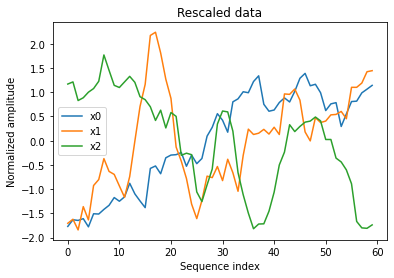


Total samples:  10000 
Training samples:  8000 
Test samples:  2000 
Sequence length:  60


In [14]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000'
fnamex = 'DATA/x_'+str0+'.csv'
fnamey = 'DATA/y_'+str0+'.csv'

x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
N = len(x)

#removing mean and standard deviation from samples
xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('Rescaled data')
plt.ylabel('Normalized amplitude')
plt.xlabel('Sequence index')
plt.legend()
plt.show()    

#one-hot encoding
categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

print('\nTotal samples: ', N,
      '\nTraining samples: ', N_train,
      '\nTest samples: ', N_val,
      '\nSequence length: ', len(x[0])
     )

#reshaping
x_train = x_train.reshape(x_train.shape[0],len(x[0]),1)
x_val = x_val.reshape(x_val.shape[0],len(x[0]),1)
input_shape = (len(x[0]),1)

In [8]:
#Ridge, lambda = 10**-2
reg = regularizers.l2(0.01)    
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()
model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 11,                      
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                )
         )
model.add(AveragePooling1D(5))                          
model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 7,
                activation = 'relu'
                )
         )
model.add(Flatten())                                      
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary())   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [9]:
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam',
              metrics = ['accuracy']
             )

#after a compilation of the network we save in 'initial.h5' the weight at the beginning
model.save_weights('initial.h5')

In [11]:
batch_size = 250
epochs = 250

fit = model.fit(x_train,
                y_train,
                batch_size = batch_size,
                epochs = epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

As we can see now the performance are really better!

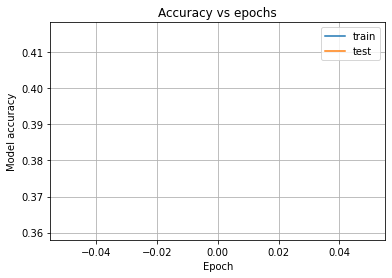

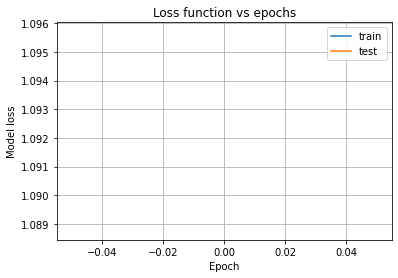

In [25]:
# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Accuracy vs epochs')
plt.ylabel('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss function vs epochs')
plt.ylabel('Model loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

## Confusion matrix and SNR augmentation

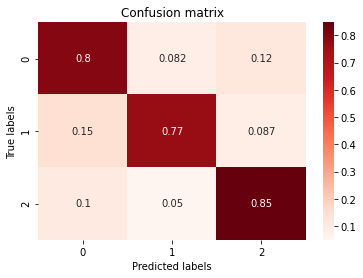

In [183]:
y_pred_val  = model.predict(x_val)

#take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
sns.heatmap(confusion_Oz, annot = True, cmap = plt.cm.Reds, fmt = '.2g')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')
plt.show()

Now we change the A parameter (from 50 to 600) in order to study the behaviour of the classifier when the noise is less and less present in the signal.

100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


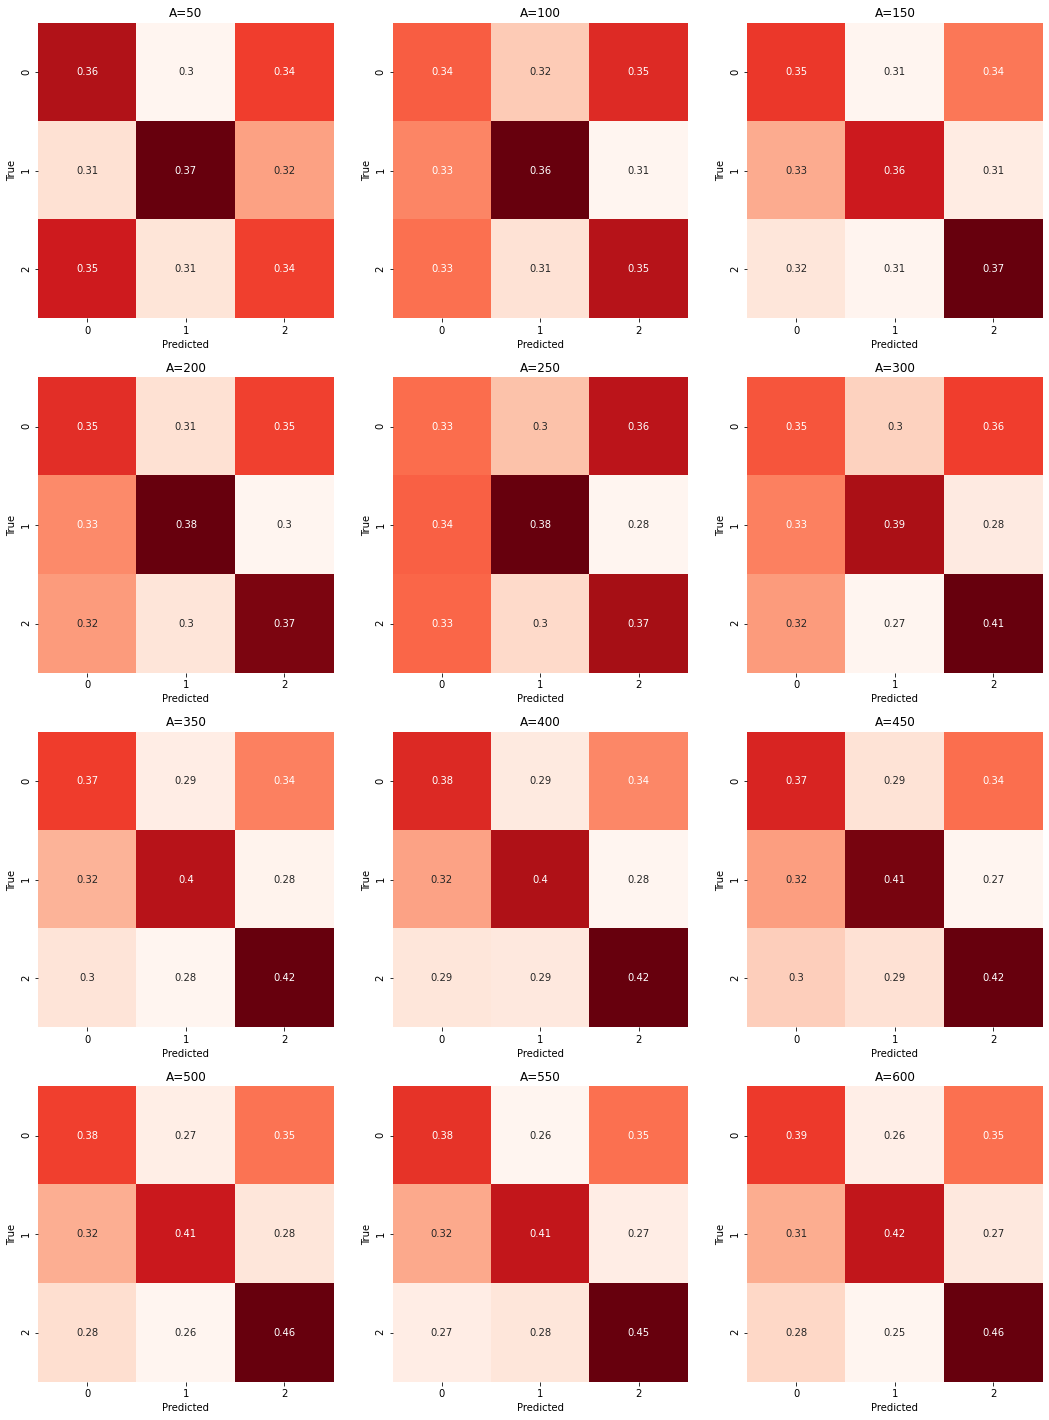

In [16]:
from tqdm import tqdm

fig, ax = plt.subplots(4, 3, figsize=(18,25))
As = np.arange(50,650,50)
scores = {}

for a in tqdm(range(len((As)))):
    
    #if statements to define the grid for the subplots
    if a < 3:
        i = 0
        j = a
    elif a < 6:
        i = 1
        j = a-3
    elif a < 9:
        i = 2
        j = a-6
    elif a < 12:
        i = 3
        j = a-9
    elif a < 15:
        i = 4
        j = a-12
    
    str0 = f'ts_L60_Z12_A{As[a]}_DX50_bias5_N10000'
    fnamex = 'DATA/x_'+str0+'.csv'
    fnamey = 'DATA/y_'+str0+'.csv'
    
    x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
    N = len(x)

    xm = x.mean(axis = 1)
    stdx = x.std(axis = 1)
    for n in range(N):
        x[n] -= xm[n]
        x[n] /= stdx[n]

    categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
    N_categ = np.max(categ)+1
    y = np.zeros((N,N_categ))
    for n in range(N):
        y[n][categ[n]] = 1             

    perc_train = 0.8                    
    N_train = int(N*perc_train)
    N_val = N - N_train

    x_train, y_train = x[:N_train], y[:N_train]
    x_val, y_val = x[N_train:], y[N_train:]

    L = len(x[0])

    x_train = x_train.reshape(x_train.shape[0],L,1)   
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)
    
    #at each step of the for loop we recover the initial weights in order to start always from the same model
    model.load_weights('initial.h5')
    fit = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    scores[As[a]] = np.mean(fit.history['accuracy'][-20:])
    
    y_pred_val  = model.predict(x_val)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)
    confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
 
    g = sns.heatmap(confusion_Oz,
                    annot = True,
                    cmap = plt.cm.Reds,
                    cbar = False,
                    fmt = '.2g',
                    ax = ax[i][j]
                   )
    g.set_ylabel('True')
    g.set_xlabel('Predicted')
    g.set_title(f'A={As[a]}')

plt.show()

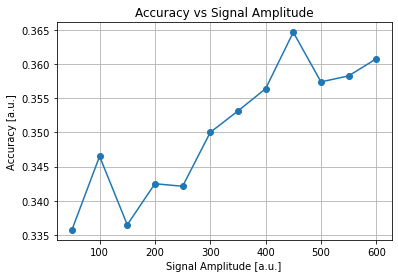

In [18]:
keys_int = []
as_accuracy = []
for k in scores.keys():
    keys_int.append(k)
    as_accuracy.append(scores.get(k))
    
plt.plot(keys_int, as_accuracy, '-o')

plt.title('Accuracy vs Signal Amplitude')
plt.xlabel('Signal Amplitude [a.u.]')
plt.ylabel('Accuracy [a.u.]')

plt.grid()
plt.show()

## Switching to ts_comp_N10000

In [15]:
str1 = 'ts_comp_N10000'
fnamex1 = 'DATA/x_'+str1+'.csv'
fnamey1 = 'DATA/y_'+str1+'.csv'

x = np.loadtxt(fnamex1, delimiter = ',', dtype = float)
categ = np.loadtxt(fnamey1, delimiter = ',', dtype = int)

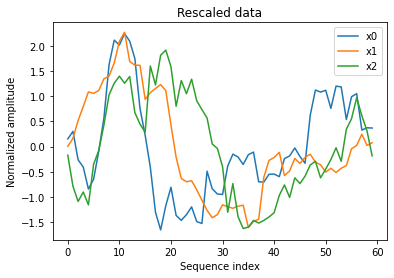


Total samples:  10000 
Training samples:  8000 
Test samples:  2000 
Sequence length:  60


In [17]:
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.xlabel('Sequence index')
plt.ylabel('Normalized amplitude')
plt.title('Rescaled data')
plt.legend()
plt.show()    

#one-hot encoding
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             

perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

print('\nTotal samples: ', N,
      '\nTraining samples: ', N_train,
      '\nTest samples: ', N_val,
      '\nSequence length: ', len(x[0])
     )

x_train = x_train.reshape(x_train.shape[0],len(x[0]),1)  
x_val = x_val.reshape(x_val.shape[0],len(x[0]),1)
input_shape = (len(x[0]),1)

Now we keep just one Conv1D layer and we see what happens when adding more and more Dense layers. The architecture of the CNN up to the first Dense layer will be always the same from now on. We did this in order to extract a common based behaviour.

In [40]:
#Ridge, lambda = 10**-2
reg = regularizers.l2(0.01)    
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

batch_size = 250
epochs = 250

In [41]:
np.random.seed(12345)
model1 = Sequential()
model1.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                      
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model1.add(AveragePooling1D(5))                          
model1.add(Flatten())            

#1xDense layer
model1.add(Dense(8,activation = 'relu'))

model1.add(Dropout(0.1))
model1.add(Dense(N_categ,activation = 'softmax'))

print(model1.summary()) 
model1.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count1 = count_params(model1.trainable_weights)

fit1 = model1.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model1.h5'
model1.save(fname, save_format='h5')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_14 (Averag (None, 11, 5)             0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 55)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 448       
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 27        
Total params: 510
Trainable params: 510
Non-trainable params: 0
_______________________________________________________

In [42]:
np.random.seed(12345)
model2 = Sequential()
model2.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model2.add(AveragePooling1D(5))                          
model2.add(Flatten())         

#2xDense layer
model2.add(Dense(8,activation = 'relu'))
model2.add(Dense(6,activation = 'relu'))

model2.add(Dropout(0.2))
model2.add(Dense(N_categ,activation = 'softmax'))

print(model2.summary()) 

model2.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count2 = count_params(model2.trainable_weights)

fit2 = model2.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model2.h5'
model2.save(fname, save_format='h5')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_15 (Averag (None, 11, 5)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 55)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 448       
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 54        
_________________________________________________________________
dropout_14 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 3)               

In [43]:
np.random.seed(12345)
model3 = Sequential()
model3.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model3.add(AveragePooling1D(5))                          
model3.add(Flatten()) 

#3xDense layer
model3.add(Dense(8,activation = 'relu'))
model3.add(Dense(6,activation = 'relu'))
model3.add(Dense(3,activation = 'relu'))

model3.add(Dropout(0.2))
model3.add(Dense(N_categ,activation = 'softmax'))

print(model3.summary()) 

model3.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count3 = count_params(model3.trainable_weights)

fit3 = model3.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model3.h5'
model3.save(fname, save_format='h5')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_16 (Averag (None, 11, 5)             0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 55)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 448       
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 21        
_________________________________________________________________
dropout_15 (Dropout)         (None, 3)               

In [44]:
np.random.seed(12345)
model4 = Sequential()
model4.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                )
          )
model4.add(AveragePooling1D(5))                          
model4.add(Flatten())          

#4xDense layer
model4.add(Dense(8,activation = 'relu'))
model4.add(Dense(6,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))
model4.add(Dense(3,activation = 'relu'))

model4.add(Dropout(0.2))
model4.add(Dense(N_categ,activation = 'softmax'))

print(model4.summary()) 

model4.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count4 = count_params(model4.trainable_weights)

fit4 = model4.fit(x_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data = (x_val,y_val),
                  verbose = 0
                   )

!mkdir MODEL
fname ='MODEL/model4.h5'
model4.save(fname, save_format='h5')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_17 (Averag (None, 11, 5)             0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 55)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 448       
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_50 (Dense)             (None, 3)               

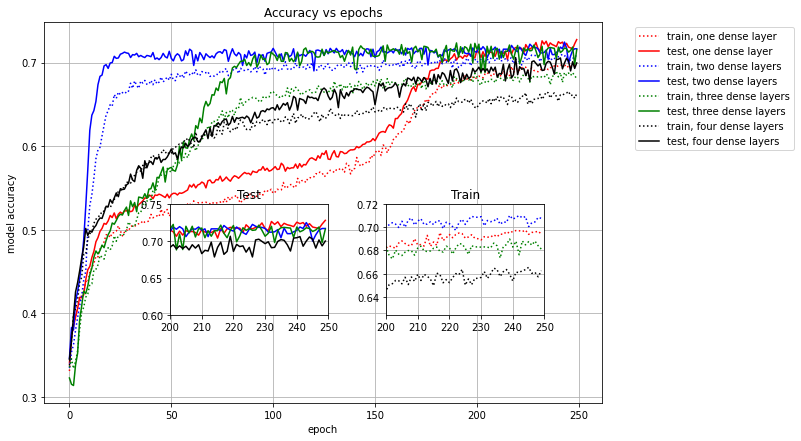

In [45]:
plt.figure(figsize=(10,7))

plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')

plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.plot(fit4.history['accuracy'], label='train, four dense layers', c='black', ls='dotted')
plt.plot(fit4.history['val_accuracy'], label='test, four dense layers', c='black')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05, 1))

# test additional axes
a = plt.axes([.3, .3, .22, .22])
plt.plot(fit1.history['val_accuracy'], label='test, one dense layers', c='r')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.plot(fit4.history['val_accuracy'], label='test, four dense layers', c='black')
plt.title('Test')
plt.xlim(200,250)
plt.ylim(0.6,0.75)
plt.grid()

# train additional axes
a = plt.axes([.6, .3, .22, .22])
plt.plot(fit1.history['accuracy'], label='train, one dense layers', c='r', ls='dotted')
plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit4.history['accuracy'], label='train, four dense layers', c='black', ls='dotted')
plt.title('Train')
plt.xlim(200,250)
plt.ylim(0.625,0.72)

plt.grid()
plt.show()

### adding conv1d

In [51]:
np.random.seed(12345)

model5 = Sequential()
model5.add(Conv1D(                                 
                filters = 5,
                kernel_size = 6,
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model5.add(AveragePooling1D(5))

model5.add(Conv1D(filters=5, kernel_size=6, activation='relu'))

model5.add(Flatten())                                    
model5.add(Dense(8,activation = 'relu'))
model5.add(Dropout(0.2))
model5.add(Dense(N_categ,activation = 'softmax'))

print(model5.summary()) 

model5.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count5 = count_params(model5.trainable_weights)

fit5 = model5.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model5.h5'
model5.save(fname, save_format='h5')

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_20 (Averag (None, 11, 5)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 6, 5)              155       
_________________________________________________________________
flatten_19 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 248       
_________________________________________________________________
dropout_19 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 3)               

In [52]:
np.random.seed(12345)

model6 = Sequential()
model6.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model6.add(AveragePooling1D(5)) 

model6.add(Conv1D(filters=5,
                  kernel_size=6,
                  activation='relu')
          )

model6.add(Conv1D(filters=5,
                  kernel_size=4,
                  activation='relu')
          )

model6.add(Flatten())                                     
model6.add(Dense(8,activation = 'relu'))
model6.add(Dropout(0.2))
model6.add(Dense(N_categ,activation = 'softmax'))

print(model6.summary()) 

model6.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

trainable_count6 = count_params(model6.trainable_weights)

fit6 = model6.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )

!mkdir MODEL
fname ='MODEL/model6.h5'
model6.save(fname, save_format='h5')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 55, 5)             35        
_________________________________________________________________
average_pooling1d_21 (Averag (None, 11, 5)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 6, 5)              155       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 3, 5)              105       
_________________________________________________________________
flatten_20 (Flatten)         (None, 15)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 8)               

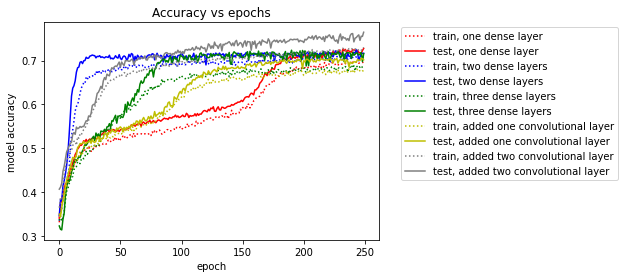

In [53]:
plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')

plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit5.history['accuracy'], label='train, added one convolutional layer', c='y', ls='dotted')
plt.plot(fit5.history['val_accuracy'], label='test, added one convolutional layer', c='y')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit6.history['accuracy'], label='train, added two convolutional layer', c='grey', ls='dotted')
plt.plot(fit6.history['val_accuracy'], label='test, added two convolutional layer', c='grey')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [77]:
import pandas as pd
df = pd.DataFrame()
convs = np.array([1, 1, 1, 1, 2, 3])
DANCINGS = np.array([1, 2, 3, 4, 1, 1])
trainable_count = np.array([trainable_count1, trainable_count2, trainable_count3, trainable_count4, trainable_count5, trainable_count6])
df['Convolutional layers'] = convs
df['Dense layers'] = DANCINGS
df['Trainable parameters'] = trainable_count
df

,Convolutional layers,Dense layers,Trainable parameters
0,1,1,510
1,1,2,558
2,1,3,570
3,1,4,582
4,2,1,465
5,3,1,450


## Regularization 

  0%|          | 0/12 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


mkdir: MODEL: File exists


  8%|▊         | 1/12 [01:31<16:45, 91.37s/it]

mkdir: MODEL: File exists


 17%|█▋        | 2/12 [02:57<14:56, 89.69s/it]

mkdir: MODEL: File exists


 25%|██▌       | 3/12 [04:55<14:45, 98.39s/it]

mkdir: MODEL: File exists


 33%|███▎      | 4/12 [06:51<13:49, 103.66s/it]

mkdir: MODEL: File exists


 42%|████▏     | 5/12 [08:37<12:09, 104.18s/it]

mkdir: MODEL: File exists


 50%|█████     | 6/12 [10:34<10:48, 108.13s/it]

mkdir: MODEL: File exists


 58%|█████▊    | 7/12 [11:54<08:18, 99.75s/it] 

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


 67%|██████▋   | 8/12 [13:12<06:13, 93.25s/it]

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


 75%|███████▌  | 9/12 [15:14<05:04, 101.65s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-0e9799ce17cf>", line 98, in <module>
    verbose = 0
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py", line 808, in fit
    use_multiprocessing=use_multiprocessing)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_arrays_v1.py", line 664, in fit
    steps_name='steps_per_epoch')
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_arrays_v1.py", line 384, in model_iteration
    batch_outs = f(ins_batch)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/pyt

KeyboardInterrupt: 

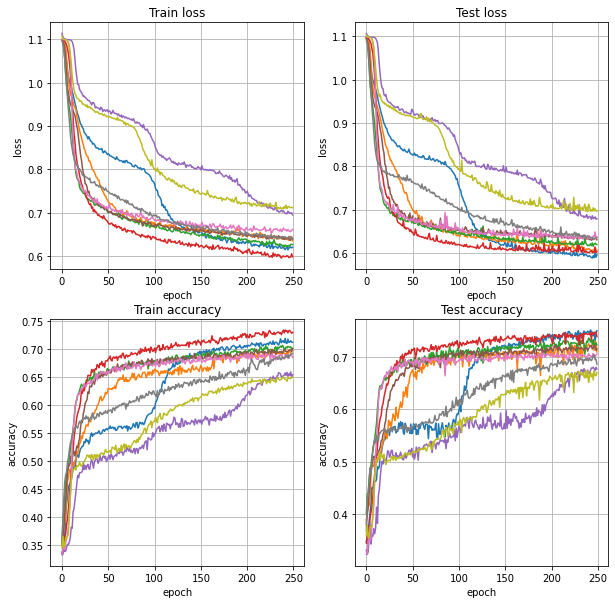

In [80]:
from tqdm import tqdm

epochs = 250

np.random.seed(12345)

def get_model(k_reg):
    model = Sequential()
    model.add(Conv1D(                                       
                filters = 5,
                kernel_size = 6,                       
                kernel_regularizer = k_reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

    model.add(AveragePooling1D(5)) 

    model.add(Conv1D(filters=5,
                     kernel_size=6,
                     activation='relu')
             )

    model.add(Conv1D(filters=5,
                     kernel_size=4,
                     activation='relu')
             )

    model.add(Flatten())                                     
    model.add(Dense(8,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ,activation = 'softmax'))

    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])
    return model

k_reg = [ 
          regularizers.l2(0.01),
          regularizers.l2(0.001),
          regularizers.l2(0.0001),
          regularizers.l2(0.00001),
          regularizers.l1(0.01),
          regularizers.l1(0.001),
          regularizers.l1(0.0001),
          regularizers.l1(0.00001),
          regularizers.l1_l2(0.01),
          regularizers.l1_l2(0.001),
          regularizers.l1_l2(0.0001),
          regularizers.l1_l2(0.00001)
        ]

vals = ['l2(0.01)',
        'l2(0.001)',
        'l2(0.0001)',
        'l2(0.00001)',
        'l1(0.01)',
        'l1(0.001)',
        'l1(0.0001)',
        'l1(0.00001)',
        'l1_l2(0.01)',
        'l1_l2(0.001)',
        'l1_l2(0.0001)',
        'l1_l2(0.00001)'
       ]

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0][0].set_title('Train loss')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('loss')
ax[0][0].grid()
ax[0][1].set_title('Test loss')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('loss')
ax[0][1].grid()
ax[1][0].set_title('Train accuracy')
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('accuracy')
ax[1][0].grid()
ax[1][1].set_title('Test accuracy')
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('accuracy')
ax[1][1].grid()

cvscores = []
for i in tqdm(range(len(k_reg))):
    model = get_model(k_reg[i])
    model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
                  optimizer = 'adam', metrics = ['accuracy'])

    fit = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    
    scores = model.evaluate(x_val, y_val, verbose=0)
    cvscores.append(scores[1] * 100)
    !mkdir MODEL
    fname ='MODEL/model_reg_' + vals[i] +'.h5'
    model.save(fname, save_format='h5')
    
    ax[0][0].plot(fit.history['loss'], label=vals[i])
    ax[0][1].plot(fit.history['val_loss'], label=vals[i])
    ax[1][0].plot(fit.history['accuracy'], label=vals[i])
    ax[1][1].plot(fit.history['val_accuracy'], label=vals[i])

lines_labels = [ax[0][1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True)

plt.show()

print(cvscores)

In [ ]:
X = [0.01,
     0.001,
     0.0001,
     0.00001]
Y1, Y2, Y3 = np.array(cvscores).reshape(3,4)
Z = ['Ridge','Lasso','Mixed']

plt.title('Accuracy for different regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Lambda factor')
plt.xscale('log')
plt.grid()
plt.xlim([5*1e-6,2e-2])
#plt.ylim([70,80])
plt.plot(X, Y1,'rs', label = Z[0])
plt.plot(X, Y2,'b.', markersize = 10, label = Z[1])
plt.plot(X, Y3,'g^', label = Z[2])

for i, v in zip(X,Y1):
    plt.text(i*1.5, v*0.999, '{:.0f}%'.format(v), ha="center")
for i, v in zip(X,Y3):
    plt.text(i*0.7, v, '{:.0f}%'.format(v), ha="center")
for i, v in zip(X,Y2):
    plt.text(i*1.5, v, '{:.0f}%'.format(v), ha="center")

plt.legend(loc=1, fancybox=True, shadow=True)
plt.show()

In [ ]:
best_loss = regularizers.l1_l2(1e-5)
worst_loss = regularizers.l1(0.01)

blank_model = get_model(best_loss)
best_after = tensorflow.keras.models.load_model('MODEL/model_reg_l1_12(0.0001).h5')
worst_after = tensorflow.keras.models.load_model('MODEL/model_reg_l1(0.01).h5')

def print_filters(model_b, model_name = 'Model'):
    for layer in model_b.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # get filter weights
        filters, biases = layer.get_weights()
        #renormalize
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        n_filters, ix = len(filters[0][0]), 1
        #define figure
        fig, ax = plt.subplots(1, n_filters, sharey = True, figsize = (11,22))
        print('\t\t\t'+model_name,layer.name, filters.shape)
        for i in range(n_filters):
            # get the filter
            f = np.array(filters[:,:,i]).T
            # plot each channel separately
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            a = ax[i].imshow(f, cmap='gray')
            ix += 1
            if i == n_filters:
                cbar = fig.colorbar(a, orientation ='horizontal', ax=ax[i])
                cbar.solids.set_edgecolor("face")
                plt.draw()
        plt.show()
    # show the figure
    
    plt.show()
    
p = print_filters(blank_model, 'prova')
q = print_filters(best_after, 'prova')
r = print_filters(worst_after, 'prova')